In [1]:
# for my own ting
%cd /home/dev/ws_neuroai

/home/dev/ws_neuroai


## RDMS BABBYYYYYY

In [2]:
!pip install wandb --quiet
import wandb, re
wandb.login(
  key=""      # <<<<<<<<<<<<<<<<<< paste your api key here
)
api = wandb.Api()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tbishnoi (utmist-parsimony). Use `wandb login --relogin` to force relogin


In [3]:
entity = "adorable-lantanas"
project = "bp-vs-wp"

project_path = f"{entity}/{project}"
runs = api.runs(project_path)

search_pattern = r"backprop" # search all runs using key

# will print details of all runs, select run id of your run
# and paste it in the next cell
n = 0
for run in reversed(runs):
    if re.search(search_pattern, run.name):
        print(f"#{n}")
        print(f"Run Name: {run.name}")
        print(f"Run ID: {run.id}")
        print("Config:", run.config)
        print("-" * 40)
        n+=1

#0
Run Name: tbishnoi-run-0-backprop-9
Run ID: 4gwtw8yi
Config: {'lr': 0.01, 'bias': True, 'entity': 'adorable-lantanas', 'epochs': 10, 'project': 'bp-vs-wp', 'momentum': 0.9, 'nesterov': True, 'batch_size': 32, 'num_hidden': 100, 'num_inputs': 784, 'num_outputs': 10, 'random_seed': 9, 'rule_select': 'backprop', 'weight_decay': 0, 'model_filepath': 'models/model-240725-225737.pth', 'activation_type': 'relu', 'experiment_name': 'tbishnoi-run-0-backprop-9'}
----------------------------------------
#1
Run Name: tbishnoi-run-0-backprop-8
Run ID: byeo296d
Config: {'lr': 0.01, 'bias': True, 'entity': 'adorable-lantanas', 'epochs': 10, 'project': 'bp-vs-wp', 'momentum': 0.9, 'nesterov': True, 'batch_size': 32, 'num_hidden': 100, 'num_inputs': 784, 'num_outputs': 10, 'random_seed': 8, 'rule_select': 'backprop', 'weight_decay': 0, 'model_filepath': 'models/model-240725-225614.pth', 'activation_type': 'relu', 'experiment_name': 'tbishnoi-run-0-backprop-8'}
---------------------------------------

In [4]:
run_id = "4gwtw8yi" # retrived from above
run_path = f"{project_path}/{run_id}"

run = api.run(run_path)

configs = run.config  # Hyperparameters and config info
summary = run.summary  # Summary metrics
history = run.history(samples=1000000)  # Full history of metrics
files = run.files()  # Files associated with the run

# show configs
configs

{'lr': 0.01,
 'bias': True,
 'entity': 'adorable-lantanas',
 'epochs': 10,
 'project': 'bp-vs-wp',
 'momentum': 0.9,
 'nesterov': True,
 'batch_size': 32,
 'num_hidden': 100,
 'num_inputs': 784,
 'num_outputs': 10,
 'random_seed': 9,
 'rule_select': 'backprop',
 'weight_decay': 0,
 'model_filepath': 'models/model-240725-225737.pth',
 'activation_type': 'relu',
 'experiment_name': 'tbishnoi-run-0-backprop-9'}

In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## RDM

In [6]:
from rules.classes.MLP import MultiLayerPerceptron 

class MLP(MultiLayerPerceptron):

    def forward(self, X, y=None):
        h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
        y_pred = self.softmax(self.lin2(h))
        return y_pred.detach(), h.detach()

def load_model(configs, device):
    model = MLP(
        num_inputs=configs['num_inputs'],
        num_hidden=configs['num_hidden'],
        num_outputs=configs['num_outputs'],
        bias=configs['bias'],
        activation_type=configs['activation_type'],
    ).to(device)

    model_filepath = configs['model_filepath']
    file = run.file(model_filepath)
    _ = file.download(replace=True, root=".")
    
    model.load_state_dict(
        torch.load(
            model_filepath,
            map_location=torch.device(device.type),
        )
    )
    return model

model = load_model(configs, device)

In [7]:
from utils.data_utils import download_mnist

_, valid_set, _ = download_mnist()

valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=configs['batch_size'], shuffle=False, drop_last=True)

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


In [54]:
X, y = next(iter(valid_loader))
X, y = X.to(device), y.to(device) 
y_pred, h = model.forward(X)
y_pred = torch.argmax(y_pred, dim=1)
y_pred

In [57]:
from collections import defaultdict

class Sampler():
    def __init__(self, dataset):
        self.dataset = defaultdict(list)
        for i, (tensor, label) in enumerate(dataset):
                self.dataset[label].append(tensor)

        self.batches = self.batch()

    def batch(self, batch_size=32):    
        all_batches = dict()
        for label, tensor_list in self.dataset.items():
            num_batches = len(tensor_list) // batch_size     
            batches = []

            for i in range(num_batches):
                my_batch = torch.stack(tensor_list[i* batch_size:(i + 1) * batch_size], dim=0)
                batches.append(my_batch)
            all_batches[label] = batches
        return all_batches  

    def tips(self):
        n = 0 
        print("classes\tcounts")
        for label, tensors in sampler.dataset.items():
            print(f"{label}\t{len(tensors)}")
            n+=len(tensors)
        print(f"n={n}")

    
sampler = Sampler(valid_set)
batches = sampler.batches

In [68]:
for chosen_class in range(2):
    batch_num = 0 
    X = batches[chosen_class][batch_num].to(device)
    y_pred, h = model.forward(X)
    y_pred = torch.argmax(y_pred, dim=1)
    # print(f"chosen_class: {chosen_class}")
    # print("predictions:")
    # print(y_pred)

chosen_class: 0
predictions:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 0], device='cuda:0')
chosen_class: 1
predictions:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


In [69]:
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [117]:
X[:3].shape

torch.Size([3, 1, 28, 28])

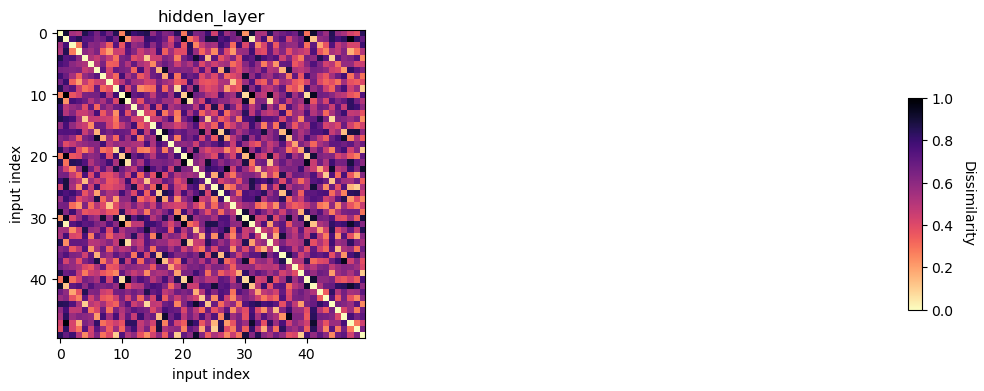

In [124]:
def plot_maps(
    model_features,
    #model_name
):
    """
    Plots representational dissimilarity matrices (RDMs) across different layers of a model.

    Inputs:
    - model_features (dict): a dictionary where keys are layer names and values are numpy arrays representing RDMs for each layer.
    - model_name (str): the name of the model being visualized.
    """


    fig = plt.figure(figsize=(14, 4))
    # fig.suptitle(f"RDMs across layers for {model_name}")
    # and we add one plot per reference point
    gs = fig.add_gridspec(1, len(model_features))
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    for l in range(len(model_features)):

        layer = list(model_features.keys())[l]
        map_ = np.squeeze(model_features[layer])

        if len(map_.shape) < 2:
            map_ = map_.reshape( (int(np.sqrt(map_.shape[0])), int(np.sqrt(map_.shape[0]))) )

        map_ = map_ / np.max(map_)

        ax = plt.subplot(gs[0,l])
        ax_ = ax.imshow(map_, cmap='magma_r')
        ax.set_title(f'{layer}')
        ax.set_xlabel("input index")
        if l==0:
            ax.set_ylabel("input index")

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
    cbar = fig.colorbar(ax_, cax=cbar_ax)
    cbar.set_label('Dissimilarity', rotation=270, labelpad=15)

    plt.show()


def calc_rdms(batches, batch_size=2):
    ds_list = list()
    feature_list = list()

    batch_num = 0    
    X = torch.cat([batches[input_class][batch_num][:batch_size].to(device) for input_class in range(0,10)], dim=1)
    y_pred, h = model.forward(X)
    y_pred = torch.argmax(y_pred, dim=1)
    
    feats = h
    if len(feats.shape) > 2:
        feats = feats.flatten(1)
    ds = Dataset(
        feats.cpu().detach().numpy(), 
        descriptors=dict(
            layer='hidden layer', batch_num=batch_num
        )
    )
    ds_list.append(ds)
    feature_list.append("hidden_layer")

    return ds_list, feature_list

method='correlation'
ds_list, feature_list = calc_rdms(batches, batch_size=5)
rdms = calc_rdm(ds_list, method=method)
rdms_dict = {feature: rdms.get_matrices()[i] for i, feature in enumerate(feature_list)}
plot_maps(rdms_dict)